# 1.Pre-requisutes

##1. Connect to Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Install the required libraries

In [2]:
!pip install torchvision

#2. Data Preprocessing

## 2.1. Import necessary libraries


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from collections import Counter
from hashlib import md5  # Import md5 for hashing

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.2 Data cleansing

In [4]:
# Load the full CIFAR-10 dataset without transformations for cleansing
raw_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

# Step 0: Analyze class distribution
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Count occurrences of each class
print("Class distribution before cleansing:")
labels = [raw_dataset[i][1] for i in range(len(raw_dataset))]
class_counts = Counter(labels)

# Print class names with their counts
for class_index, count in class_counts.items():
    print(f"{class_names[class_index]}: {count}")

# Step 1: Check for corrupted images
print("\nChecking for corrupted images...")
valid_indices = []
for i in range(len(raw_dataset)):
    try:
        img, label = raw_dataset[i]
        valid_indices.append(i)  # Keep track of valid indices
    except (IOError, ValueError) as e:
        print(f"Corrupted image at index {i}: {e}")

# Filter dataset to remove corrupted images
raw_dataset = torch.utils.data.Subset(raw_dataset, valid_indices)

# Step 2: Check and remove duplicate images
print("\nChecking for duplicate images...")
hashes = {}
unique_indices = []
for i in range(len(raw_dataset)):
    img, label = raw_dataset[i]
    img_hash = md5(np.array(img).tobytes()).hexdigest()
    if img_hash not in hashes:
        hashes[img_hash] = i
        unique_indices.append(i)
    else:
        print(f"Duplicate found: Index {i} is a duplicate of Index {hashes[img_hash]}")

# Filter dataset to retain only unique images
raw_dataset = torch.utils.data.Subset(raw_dataset, unique_indices)

# Step 3: Analyze class distribution
print("\nClass distribution after cleansing:")

# Count occurrences of each class
labels = [raw_dataset[i][1] for i in range(len(raw_dataset))]
class_counts = Counter(labels)

# Print class names with their counts
for class_index, count in class_counts.items():
    print(f"{class_names[class_index]}: {count}")

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Class distribution before cleansing:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000

Checking for corrupted images...

Checking for duplicate images...

Class distribution after cleansing:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


## 2.3. Data transformation

In [5]:
class CutOut(object):
    def __init__(self, n_holes, length):
        """
        Initializes the CutOut transformation.

        Args:
        n_holes (int): How many regions (holes) to remove from the image.
        length (int): The size (length of the side) of each square hole.
        """
        self.n_holes = n_holes  # Store the number of holes to create.
        self.length = length    # Store the size of each hole.

    def __call__(self, img):
        """
        Applies the CutOut transformation to the input image.

        Args:
        img (torch.Tensor): The input image with dimensions (Channels, Height, Width).

        Returns:
        torch.Tensor: The transformed image with random square holes cut out.
        """
        # Get the height and width of the image.
        h, w = img.size(1), img.size(2)

        # Create a mask filled with ones to determine which parts of the image remain and which get removed.
        mask = np.ones((h, w), np.float32)

        # Create the specified number of holes in the mask.
        for n in range(self.n_holes):
            # Randomly pick the center of a square hole.
            y = np.random.randint(h)  # y-coordinate.
            x = np.random.randint(w)  # x-coordinate.

            # Calculate the boundaries of the square hole.
            # Clip values to ensure the hole stays within the image dimensions.
            y1 = np.clip(y - self.length // 2, 0, h)  # Top edge of the square.
            y2 = np.clip(y + self.length // 2, 0, h)  # Bottom edge of the square.
            x1 = np.clip(x - self.length // 2, 0, w)  # Left edge of the square.
            x2 = np.clip(x + self.length // 2, 0, w)  # Right edge of the square.

            # Set the mask values in the square region to zero (this part of the image will be removed).
            mask[y1:y2, x1:x2] = 0.

        # Convert the mask to a PyTorch tensor.
        mask = torch.from_numpy(mask)

        # Match the mask dimensions to the input image.
        mask = mask.expand_as(img)

        # Multiply the image by the mask.
        # The parts of the image where the mask is zero will be removed (set to black).
        img = img * mask

        # Return the modified image.
        return img

# Data Augumentation on train data
transform_train = transforms.Compose([
    # Randomly flip the image horizontally with a 50% chance.
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image by up to 30 degrees in either direction.
    transforms.RandomRotation(30),

    # Apply a random affine transformation:
    # - Rotate by up to 15 degrees
    # - Translate horizontally or vertically by as much as 10% of the image in its dimension.
    # - Scale image to a value randomly ranging between 90% and 110% of the original image size.
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    # Randomly change color properties of the image:
    # - Brightness, contrast, saturation changed by ±20%
    # - Hue can change by ±10%
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # Randomly turn an image into grayscale (10% chance) to simulate 'black-and-white situations'.
    transforms.RandomGrayscale(p=0.1),

    # Randomly cut an image to 32x32 pixels with up to 4 pixels of padding before cropping.
    transforms.RandomCrop(32, padding=4),

    transforms.ToTensor(),

    # Standarize the data to zero mean and 1 standard deviation.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

    # Apply the CutOut augmentation to randomly mask one square region of size 8x8 pixels.
    # This helps improve model robustness by forcing it to focus on other features in the image.
    CutOut(n_holes=1, length=8)
])


# Data Augumentation on test data
transform_test = transforms.Compose([
    # Resize the images into 32 x 32.
    transforms.Resize((32, 32)),  # Resize to 32x32

    transforms.ToTensor(),

    # Standarize the data to zero mean and 1 standard deviation.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

## 2.4. Split data into train, validation and test set

In [6]:
from torch.utils.data import random_split

# Load CIFAR-10 dataset with transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Train, test and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# Print dataset sizes
print(f"Training Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")
print(f"Test Set: {len(test_dataset)} samples")

Training Set: 45000 samples
Validation Set: 5000 samples
Test Set: 10000 samples


#3 Exploratory Data Analysis (EDA)

## 3.1 Print data distribution

In [8]:
import numpy as np
import pandas as pd
from collections import Counter

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get class labels from the dataset splits
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
test_labels = [label for _, label in test_dataset]

# Count occurrences of each class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

# Create a DataFrame for better visualization
data_stats = pd.DataFrame({
    "Class": class_names,
    "Train Count": [train_counts[i] for i in range(10)],
    "Validation Count": [val_counts[i] for i in range(10)],
    "Test Count": [test_counts[i] for i in range(10)]
})

print("Class distribution statistics:\n", data_stats)

Class distribution statistics:
         Class  Train Count  Validation Count  Test Count
0    airplane         4499               501        1000
1  automobile         4542               458        1000
2        bird         4483               517        1000
3         cat         4485               515        1000
4        deer         4487               513        1000
5         dog         4508               492        1000
6        frog         4510               490        1000
7       horse         4476               524        1000
8        ship         4497               503        1000
9       truck         4513               487        1000


## 3.2 Plot the data distribution across the classes

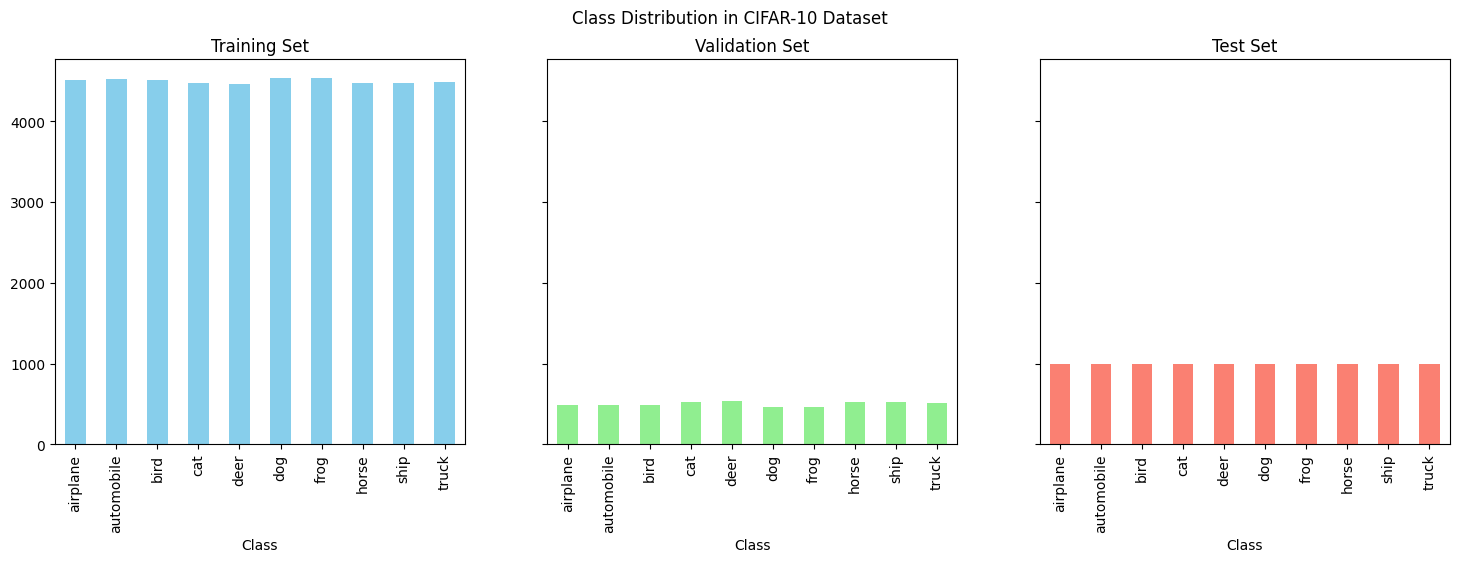

In [ ]:
import matplotlib.pyplot as plt

# Plot class distribution
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
data_stats.plot(x='Class', y='Train Count', kind='bar', ax=ax[0], color='skyblue', legend=False)
data_stats.plot(x='Class', y='Validation Count', kind='bar', ax=ax[1], color='lightgreen', legend=False)
data_stats.plot(x='Class', y='Test Count', kind='bar', ax=ax[2], color='salmon', legend=False)
ax[0].set_title("Training Set")
ax[1].set_title("Validation Set")
ax[2].set_title("Test Set")
plt.suptitle("Class Distribution in CIFAR-10 Dataset")
plt.show()


## 3.3 Data Statistics

In [ ]:
# Calculate mean and std for training set
train_images = np.stack([img.permute(1, 2, 0).numpy() for img, _ in train_dataset])
train_mean = train_images.mean(axis=(0, 1, 2))
train_std = train_images.std(axis=(0, 1, 2))

print("Training Set Mean:", train_mean)
print("Training Set Standard Deviation:", train_std)

# Calculate mean and std for validation set
val_images = np.stack([img.permute(1, 2, 0).numpy() for img, _ in val_dataset])
val_mean = val_images.mean(axis=(0, 1, 2))
val_std = val_images.std(axis=(0, 1, 2))

print("Validation Set Mean:", val_mean)
print("Validation Set Standard Deviation:", val_std)

# Calculate mean and std for test set
test_images = np.stack([img.permute(1, 2, 0).numpy() for img, _ in test_dataset])
test_mean = test_images.mean(axis=(0, 1, 2))
test_std = test_images.std(axis=(0, 1, 2))

print("Test Set Mean:", test_mean)
print("Test Set Standard Deviation:", test_std)

Training Set Mean: [-0.58826464 -0.59429055 -0.5316244 ]
Training Set Standard Deviation: [1.4249704 1.4271048 1.4040647]
Validation Set Mean: [-0.5946216 -0.6004178 -0.5363783]
Validation Set Standard Deviation: [1.4286361 1.429755  1.40991  ]
Test Set Mean: [0.01391149 0.01470116 0.01944823]
Test Set Standard Deviation: [1.2192415 1.2181147 1.3014553]


## 3.4 Example image from each class

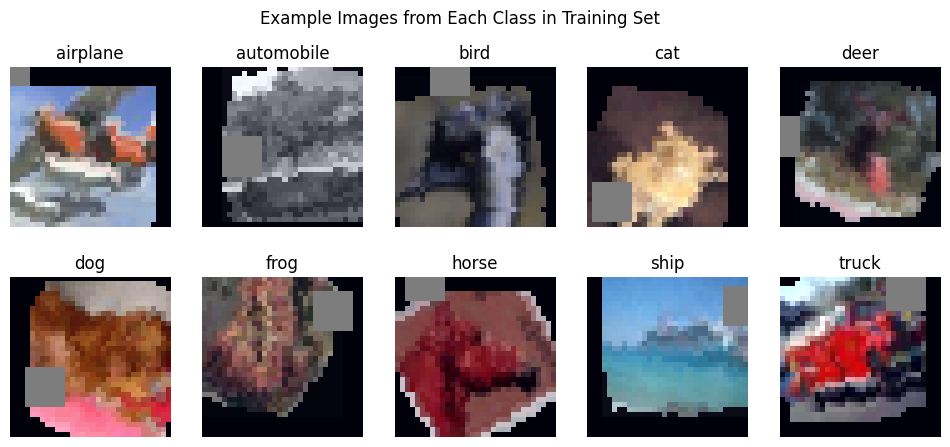

In [ ]:
# Plot examples of each class
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    # Find the first image in each class
    idx = train_labels.index(i)
    img, label = train_dataset[idx]
    axes[i].imshow(img.permute(1, 2, 0).numpy() * 0.2023 + 0.4914)  # De-normalize for visualization
    axes[i].set_title(class_names[label])
    axes[i].axis('off')

plt.suptitle("Example Images from Each Class in Training Set")
plt.show()

## 3.5. Examples of Augumented images

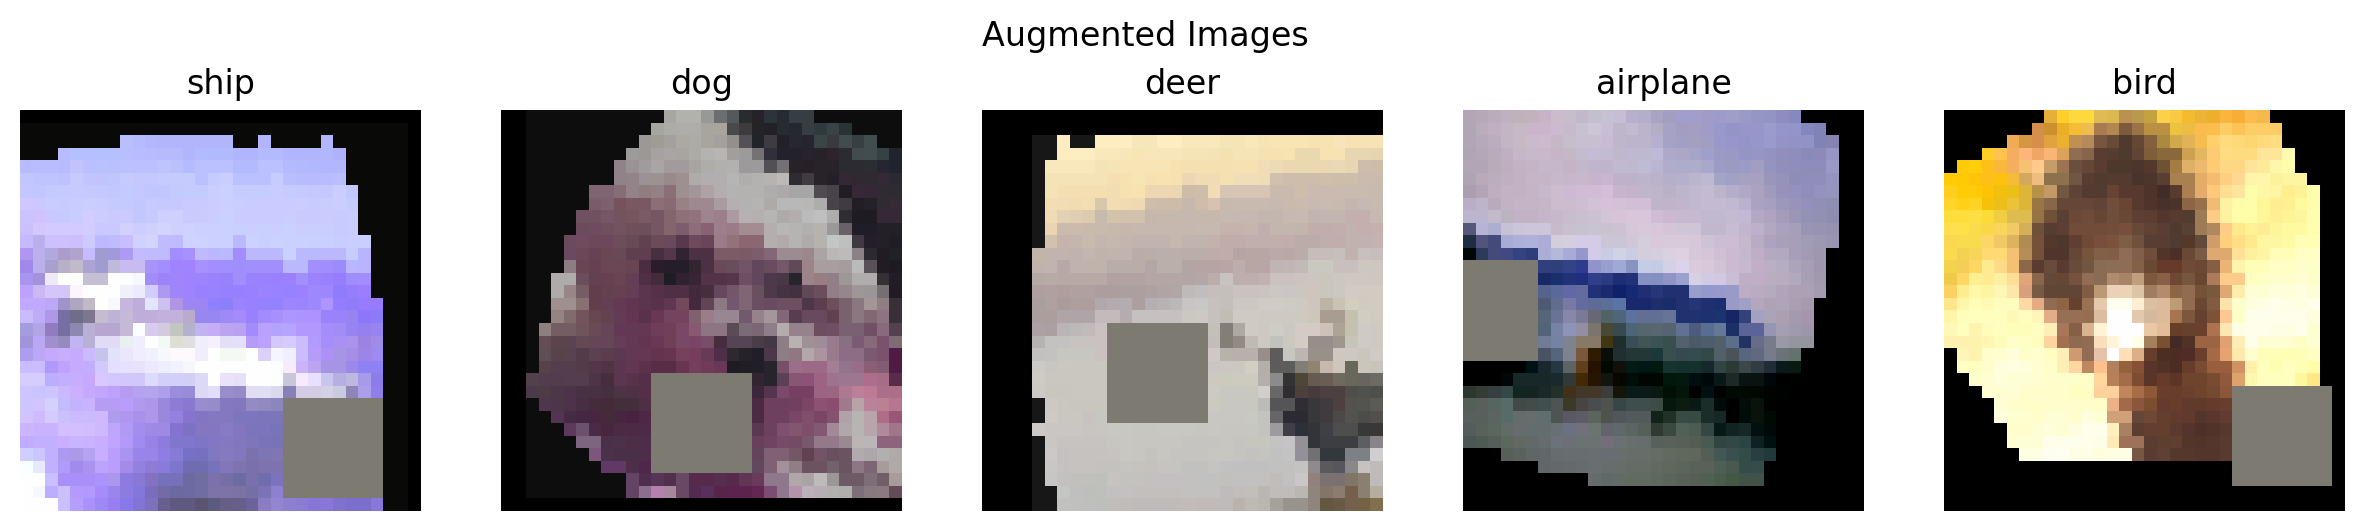

In [ ]:
# Define a DataLoader for augmented images
aug_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

# Display augmented images for a single batch
batch = next(iter(aug_loader))
images, labels = batch

fig, axes = plt.subplots(1, 5, figsize=(15, 3), dpi=200)
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])  # De-normalize
    axes[i].imshow(np.clip(img, 0, 1))  # Clip values for display
    axes[i].set_title(class_names[labels[i].item()])
    axes[i].axis('off')
plt.suptitle("Augmented Images")
plt.show()

## 3.6. Dimentionality Reduction

In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
import matplotlib.pyplot as plt

def collect_data(loader):
    X = []
    y = []
    for images, labels in loader:
        # Flatten images to 2D: (batch_size, channels * height * width)
        flattened = images.view(images.size(0), -1)
        X.append(flattened)
        y.append(labels)
    return torch.cat(X, dim=0), torch.cat(y, dim=0)

# Collect training data and labels
X, y = collect_data(train_loader)
X = X.numpy()
y = y.numpy()

# Normalize the data
X = X / 255.0  # Scale pixel values to [0, 1]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 3.6.1. PCA on Train data

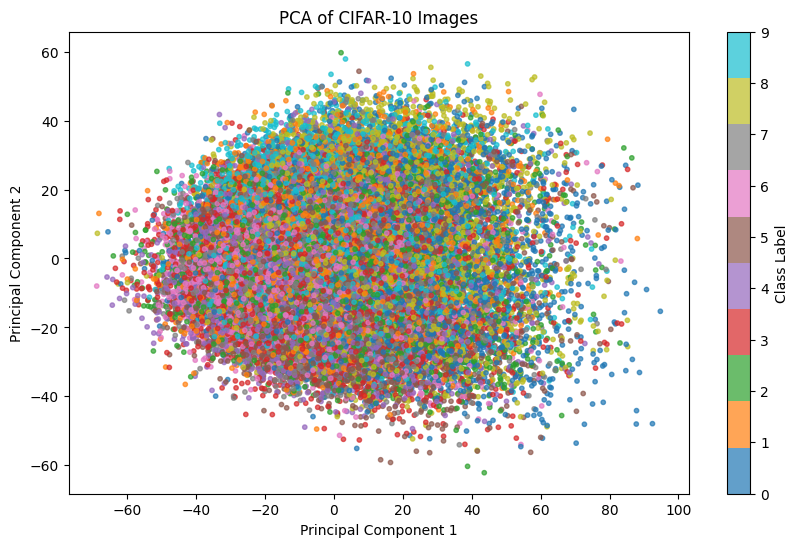

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(label='Class Label')
plt.title('PCA of CIFAR-10 Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Explained Variance Ratio for each component: [1.58062890e-01 1.04084074e-01 9.29642022e-02 ... 1.23344122e-07
 1.22822044e-07 1.10941450e-07]
Cumulative Explained Variance: [0.15806289 0.26214695 0.35511115 ... 1.0000005  1.0000006  1.0000007 ]


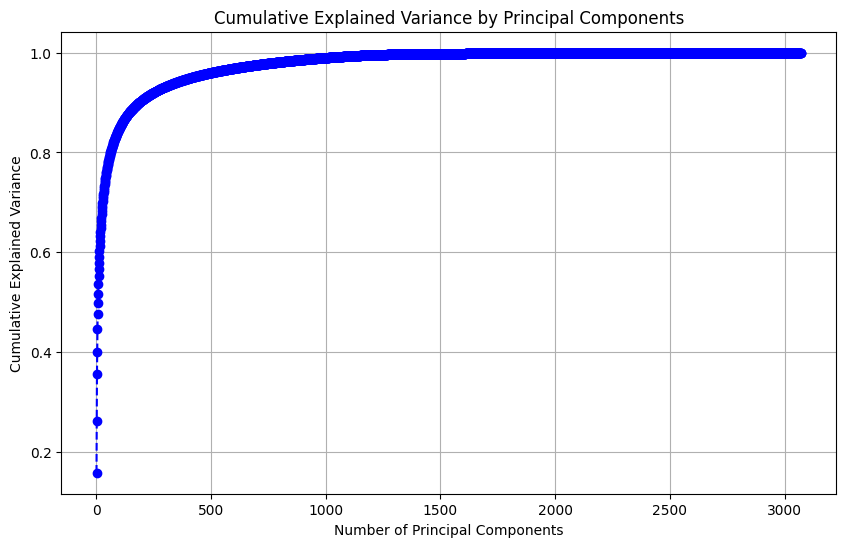

In [ ]:
# Calculate explianed variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Explained Variance Ratio for each component:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)

# Plot the explained variance ratio vs num_components.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

plt.grid()
plt.show()

This graph tell us that its enough to focus on the first 500–1000 components, which likely retain a high percentage (e.g., ~95%) of the total variance, reducing computational complexity without significant information loss.

### 3.6.2. TSNE on Train Data

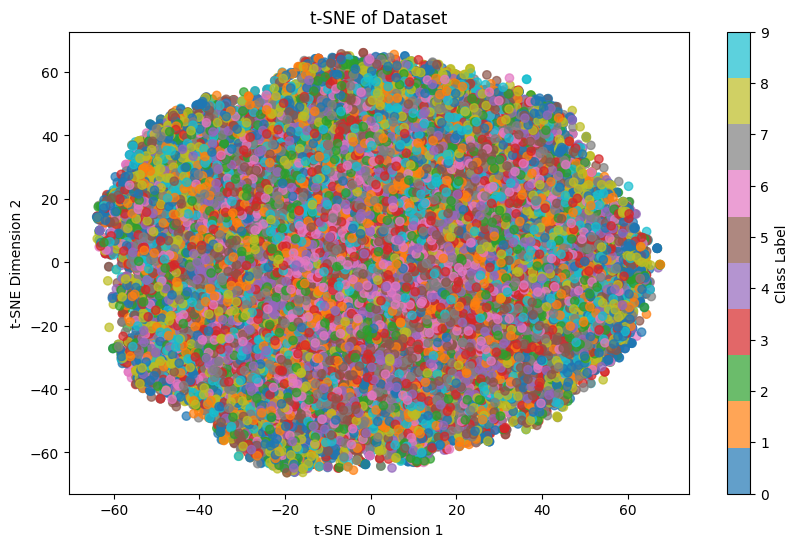

In [ ]:
from sklearn.manifold import TSNE

# Assume X is your high-dimensional dataset
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualize the t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.colorbar(label='Class Label')
plt.title('t-SNE of Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# 4. Model Selection - ResNet34

## 4.1 Algorithm Selection

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):

        """
        Initialize a residual block for ResNet.

        Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int, optional): Stride for the first convolution layer. Default is 1.

        Description:
        Define a Residual Block for the ResNet model
        It consists of two convolutional layers, batch normalization, ReLU activation, and a skip connection.
        Skip connectivity allows gradients to go forward directly into earlier layers and
        prevents vanishing gradient problems.
        """
        super(ResidualBlock, self).__init__()
        # First convolutional layer in the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer in the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Dropout is added with a rate of 50% to improve regularization and reduce overfitting
        self.dropout = nn.Dropout(0.5)

        # Define the skip connection. If the input and output dimensions differ, use a 1x1 convolution to match them.
        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """
        Forward pass through the residual block.

        Args:
        x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
        torch.Tensor: Output tensor after applying the residual block.
        """
        # Save the original input for the skip connection
        identity = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply dropout after the second convolution
        out = self.dropout(out)

        # Add the skip connection
        out += identity

        # Apply ReLU activation to the result
        return self.relu(out)

# Define the ResNet-34 model using the Residual Blocks
class ResNet34(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """
        Initialize the ResNet-34 architecture.

        Args:
        block (nn.Module): Instance of Residual block class.
        num_blocks (list): Number of residual blocks for each layer group.
        num_classes (int, optional): Number of output classes for classification. Default is 10.

        Description:
        ResNet-34 is a deep convolutional neural network architecture comprising an initial convolutional layer,
        4 groups of residual layers, and a fully connected layer. In this model, skip connections are used to
        improve gradient flow and stability during training.
        """
        super(ResNet34, self).__init__()
        self.in_channels = 64  # Initial number of channels for the input layer

        # First convolutional layer for preprocessing
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Define the layers of the ResNet model
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)   # First group of residual blocks
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # Second group with downsampling
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # Third group with more channels
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # Fourth group with the highest channels

        # Global average pooling and a fully connected layer for classification
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        """
        Create a layer group consisting of multiple residual blocks.

        Args:
        block (nn.Module): Residual block class to use.
        out_channels (int): Number of output channels for the blocks in this layer group.
        blocks (int): Number of residual blocks in this layer group.
        stride (int): Stride for the first block in the group.

        Returns:
        nn.Sequential: Sequential container of residual blocks for this layer group.
        """

        # First block may downsample, others maintain stride of 1
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # Update the input channels for the next block
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the ResNet-34 model.

        Args:
        x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)

        # Flatten the spatial dimensions for the fully connected layer
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Instantiate the model.
model = ResNet34(ResidualBlock, [3, 4, 6, 3]).to(device)

# Define the loss function. This works well with clasification problems.
criterion = nn.CrossEntropyLoss()

# Define the optimizer (AdamW with weight decay for better regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 80
steps_per_epoch = len(train_loader)  # Number of batches in each epoch
total_steps = steps_per_epoch * num_epochs  # Total number of steps for 80 epochs

# Define a learning rate scheduler (OneCycleLR for dynamic learning rate adjustment during training)
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,          # Maximum learning rate
    total_steps=total_steps,  # Total training steps
    pct_start=0.3,         # Warm-up period (30% of total steps)
    anneal_strategy='cos', # Cosine annealing for learning rate decay
    div_factor=25.0        # Initial learning rate is max_lr / div_factor
)


## 4.2. Helper Methods - Evaluation, Train_one_epoch, Save state, Load State

In [18]:
import os
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")

checkpoint_path = "/content/drive/MyDrive/Data Mining/Project/resnet34_cifar10_checkpoint.pth"

def evaluate(loader, model, device):
    """
    Evaluate the model on a given data loader.

    Args:
    loader (torch.utils.data.DataLoader): The data loader containing the dataset to evaluate.

    Returns:
    tuple: A tuple containing the following metrics:
      - accuracy (float): The percentage of correctly classified samples.
      - precision: float. The weighted average precision score across all classes.
      - recall (float): The weighted average recall score across all classes.
      - f1 (float): The weighted average F1 score across all classes.

    Description:
      1. This function sets the model to evaluation mode-deactivating both dropout and updating batch normalization statistic.
      2. Iterates through the dataset and computes the following key evaluation metrics: accuracy, precision, recall, and F1 score.
      3. These metrics are computed comparing the predictions with true targets.
      4.  All computations without gradient updates(`torch.no_grad()`), ensuring that the evaluation process does not affect the model.

      Steps:
      1. Pass each batch through the model to get predictions.
      2. Compare predictions with ground truth to calculate the number of correct predictions.
      3. Collect all predictions and true labels for calculating precision, recall, and F1 scores.
      4. Return the computed metrics for analysis.
    """
    model.eval()
    correct, total = 0, 0
    all_targets, all_preds = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = 100. * correct / total
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    return accuracy, precision, recall, f1

# Function to load checkpoint
def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    """
    Load the training checkpoint if it exists.

    Args:
    - model (nn.Module): The model to load weights into.
    - optimizer (torch.optim.Optimizer): The optimizer to load state into.
    - scheduler (torch.optim.lr_scheduler, optional): The learning rate scheduler to load state into.
    - checkpoint_path (str): Path to the checkpoint file.

    Returns:
    - int: The starting epoch to resume training.
    """
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}")
        return start_epoch
    return 0

# Function to train for one epoch
def train_one_epoch(epoch, model, train_loader, criterion, optimizer, scheduler, device):
    """
    Perform one epoch of training.

    Args:
    - epoch (int): Current epoch number.
    - model (nn.Module): The model to train.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - criterion (nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer to update weights.
    - scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
    - device (torch.device): The device to train on.

    Returns:
    - float: Average training loss for the epoch.
    """
    model.train()
    running_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Function to save checkpoint
def save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss, checkpoint_path):
    """
    Save the training checkpoint.

    Args:
    - epoch (int): Current epoch number.
    - model (nn.Module): The model to save.
    - optimizer (torch.optim.Optimizer): The optimizer to save.
    - scheduler (torch.optim.lr_scheduler): The scheduler to save.
    - train_loss (float): The training loss for the epoch.
    - val_loss (float): The validation loss for the epoch.
    - checkpoint_path (str): Path to save the checkpoint file.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, checkpoint_path)


## 4.3 Build Model (Train)




In [ ]:
# Main training function
def train_model(model, train_loader, val_loader, test_loader, num_epochs, criterion, optimizer, scheduler, device, checkpoint_path):
    """
    Train and evaluate the model while tracking all key metrics for visualization.

    Args:
    - model (nn.Module): The model to train.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
    - num_epochs (int): Number of epochs to train.
    - criterion (nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer to update weights.
    - scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
    - device (torch.device): The device to train on.
    - checkpoint_path (str): Path to save/load the checkpoint.

    Returns:
    - dict: A dictionary containing training and validation metrics history.
    """
    # Load checkpoint if available
    start_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_path)

    # Initialize metric tracking lists
    train_accuracy_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], []
    val_accuracy_history, val_precision_history, val_recall_history, val_f1_history = [], [], [], []
    train_loss_history, val_loss_history = [], []

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        # Train for one epoch
        train_loss = train_one_epoch(epoch, model, train_loader, criterion, optimizer, scheduler, device)
        train_loss_history.append(train_loss)

        # Evaluate on training set
        train_accuracy, train_precision, train_recall, train_f1 = evaluate(train_loader, model, device)
        train_accuracy_history.append(train_accuracy)
        train_precision_history.append(train_precision)
        train_recall_history.append(train_recall)
        train_f1_history.append(train_f1)

        # Evaluate on validation set
        val_accuracy, val_precision, val_recall, val_f1 = evaluate(val_loader, model, device)
        val_accuracy_history.append(val_accuracy)
        val_precision_history.append(val_precision)
        val_recall_history.append(val_recall)
        val_f1_history.append(val_f1)

        # Print metrics for the epoch
        print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
          f"Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f} | Train F1 Score: {train_f1:.4f} | "
          f"Validation Accuracy: {val_accuracy:.2f}% | Validation Precision: {val_precision:.4f} | "
          f"Validation Recall: {val_recall:.4f} | Validation F1 Score: {val_f1:.4f}")

        # Save checkpoint at the end of each epoch
        save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss_history[-1] if val_loss_history else None, checkpoint_path)


    # Return all history as a dictionary
    return {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_accuracy': train_accuracy_history,
        'val_accuracy': val_accuracy_history,
        'train_precision': train_precision_history,
        'val_precision': val_precision_history,
        'train_recall': train_recall_history,
        'val_recall': val_recall_history,
        'train_f1': train_f1_history,
        'val_f1': val_f1_history
    }


In [ ]:
# Train the model
history = train_model(model, train_loader, val_loader, test_loader, num_epochs, criterion, optimizer, scheduler, device, checkpoint_path)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/80 | Train Loss: 2.1924 | Train Accuracy: 10.75% | Train Precision: 0.1552 | Train Recall: 0.1075 | Train F1 Score: 0.0381 | Validation Accuracy: 11.52% | Validation Precision: 0.1729 | Validation Recall: 0.1152 | Validation F1 Score: 0.0412


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/80 | Train Loss: 2.0315 | Train Accuracy: 12.91% | Train Precision: 0.2071 | Train Recall: 0.1291 | Train F1 Score: 0.0622 | Validation Accuracy: 13.74% | Validation Precision: 0.1887 | Validation Recall: 0.1374 | Validation F1 Score: 0.0657
Epoch 3/80 | Train Loss: 1.9048 | Train Accuracy: 13.70% | Train Precision: 0.2145 | Train Recall: 0.1370 | Train F1 Score: 0.0646 | Validation Accuracy: 13.88% | Validation Precision: 0.1637 | Validation Recall: 0.1388 | Validation F1 Score: 0.0622
Epoch 4/80 | Train Loss: 1.8027 | Train Accuracy: 17.98% | Train Precision: 0.3029 | Train Recall: 0.1798 | Train F1 Score: 0.1488 | Validation Accuracy: 18.28% | Validation Precision: 0.2938 | Validation Recall: 0.1828 | Validation F1 Score: 0.1486
Epoch 5/80 | Train Loss: 1.7147 | Train Accuracy: 21.34% | Train Precision: 0.3187 | Train Recall: 0.2134 | Train F1 Score: 0.1846 | Validation Accuracy: 20.18% | Validation Precision: 0.3049 | Validation Recall: 0.2018 | Validation F1 Score: 0.1725


## 4.4 Evaluate Model on Test Data

In [ ]:
# Final evaluation on the test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader, model, device)
print("\nFinal Test Evaluation:")
print(f"Test Accuracy: {test_accuracy:.2f}% | Precision: {test_precision:.4f} | "
      f"Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")


Final Test Evaluation:
Test Accuracy: 90.76% | Precision: 0.9091 | Recall: 0.9076 | F1 Score: 0.9078


## 4.5 Plot the metrics

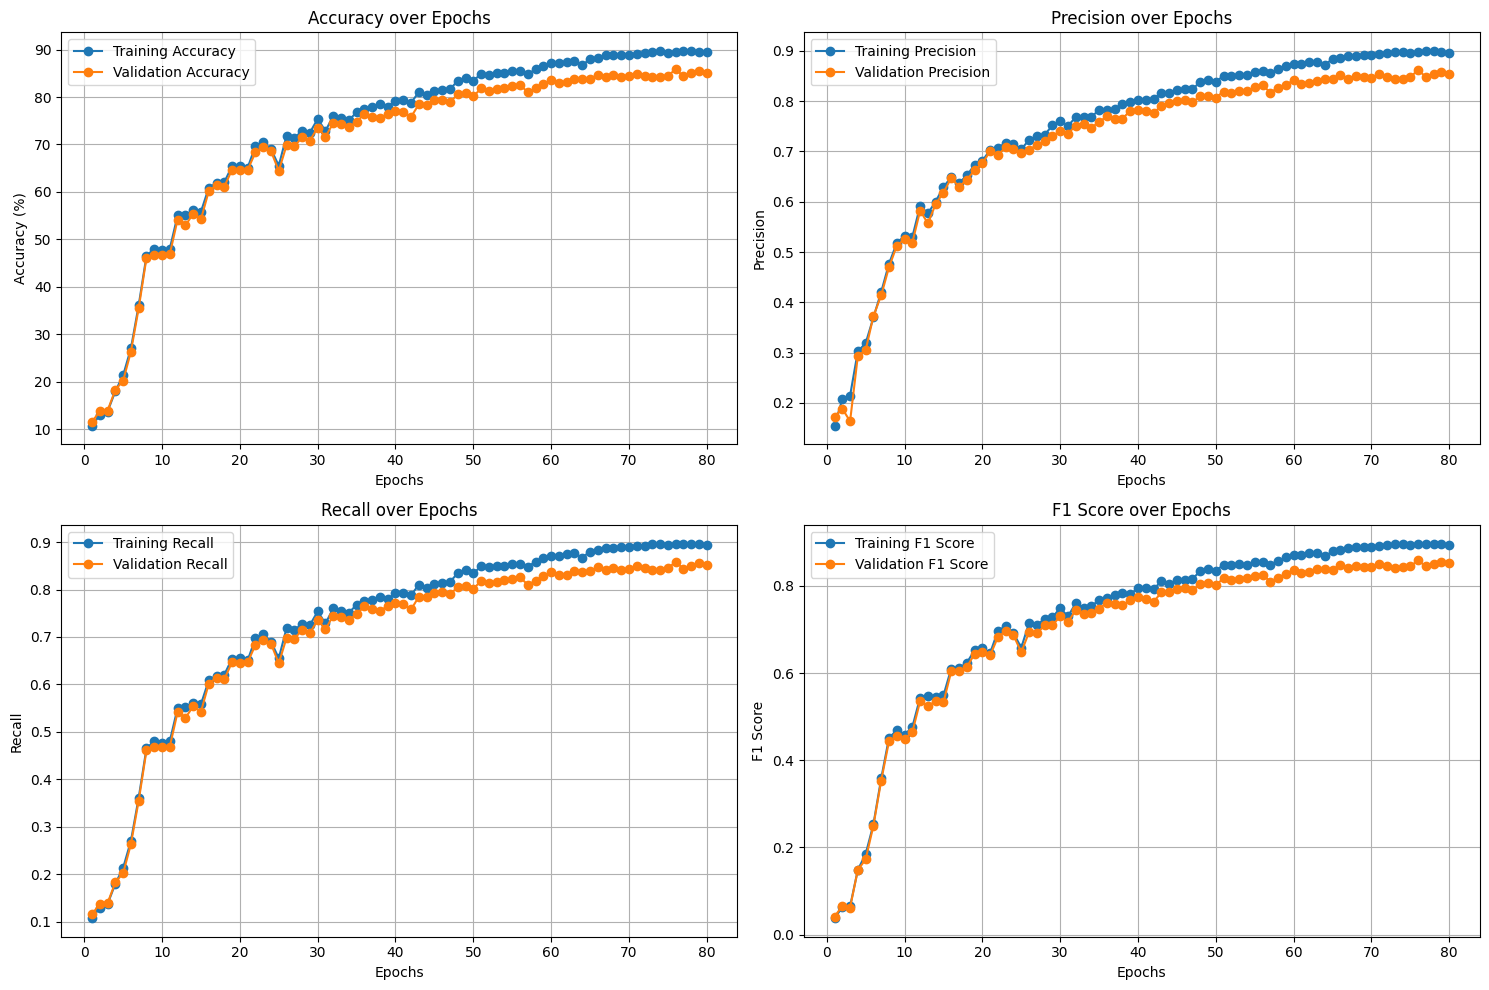

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Extract values from the history dictionary
train_accuracy_history = history['train_accuracy']
val_accuracy_history = history['val_accuracy']
train_precision_history = history['train_precision']
val_precision_history = history['val_precision']
train_recall_history = history['train_recall']
val_recall_history = history['val_recall']
train_f1_history = history['train_f1']
val_f1_history = history['val_f1']

plt.figure(figsize=(15, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy_history, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy_history, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, train_precision_history, label='Training Precision', marker='o')
plt.plot(epochs, val_precision_history, label='Validation Precision', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()
plt.grid()

# Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, train_recall_history, label='Training Recall', marker='o')
plt.plot(epochs, val_recall_history, label='Validation Recall', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()
plt.grid()

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1_history, label='Training F1 Score', marker='o')
plt.plot(epochs, val_f1_history, label='Validation F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


#5. Confusion Matrix

In [16]:
# Load the saved model
model_path = "/content/drive/MyDrive/DM_Project/resnet34_cifar10_checkpoint_new.pth"

model_loaded = ResNet34(ResidualBlock, [3, 4, 6, 3]).to(device)
checkpoint = torch.load(model_path)
print(checkpoint.keys())
model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval()

<ipython-input-16-40682b027134>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_loss', 'val_loss'])


ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (skip_connection): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [26]:
def plot_confusion_matrix(loader, model, device, save_path='confusion_matrix.jpeg'):
    """
    Plots a confusion matrix for the given model and dataset.

    Args:
        loader (DataLoader): DataLoader for the dataset to evaluate the model.
        model (torch.nn.Module): Trained model to evaluate.
        device (torch.device): Device (CPU or GPU) to perform computations.
        class_names (list): List of class names corresponding to dataset labels.
        save_path (str, optional): Path to save the generated confusion matrix image. Default is 'confusion_matrix.jpeg'.

    Description:
        This function computes predictions using the provided model and dataset loader,
        calculates a confusion matrix, and visualizes it using a heatmap.
    """
    model.eval()  # Set the model to evaluation mode
    all_targets, all_preds = [], []
    class_names = test_dataset.classes

    with torch.no_grad():  # Disable gradient calculation for faster inference
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)  # Get predicted class labels
            all_targets.extend(targets.cpu().numpy())  # Collect true labels
            all_preds.extend(preds.cpu().numpy())      # Collect predictions

    # Compute the confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=1,
        linecolor='black'
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(save_path)  # Save the heatmap image
    plt.show()

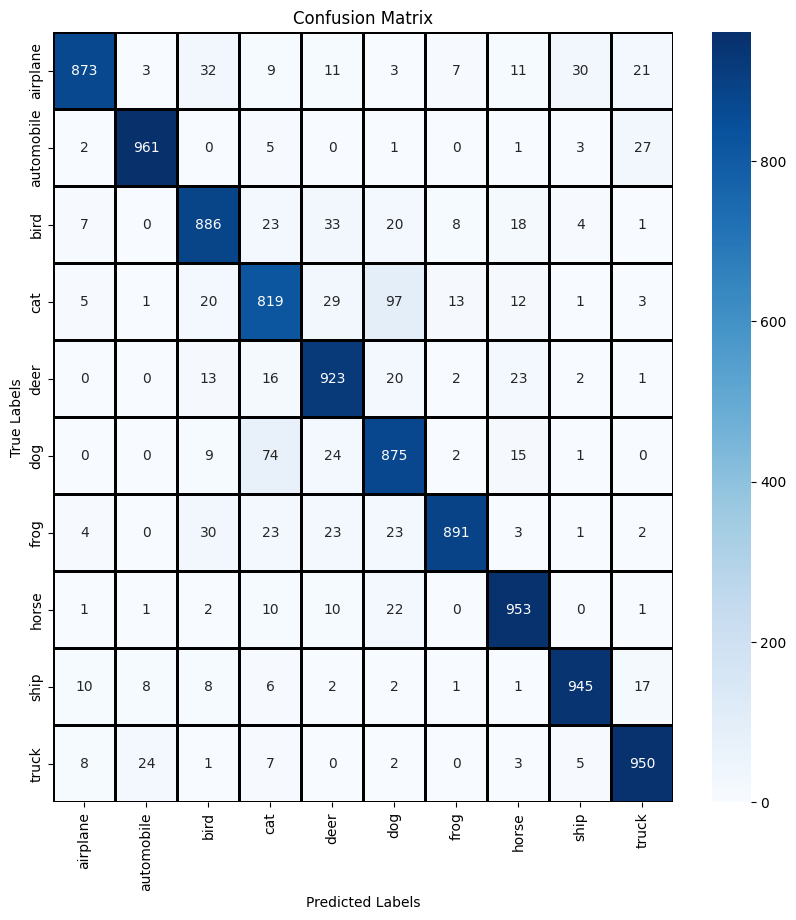

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plot_confusion_matrix(test_loader, model_loaded, device)